# Exercise 5 (RBM)

21_centuryboys
Mattia Ceravolo, Lorenzo Borella, Samuele Pio Lipani, Marco Giunta

In [1]:
import numpy as np 
import random 
import csv
import matplotlib.pyplot as plt 

## Loading the data

In [2]:
#load clean data
q = 0.0
fname = 'DATA/dataRBM_q'+str(q)+'.csv'
v = np.loadtxt(fname, delimiter = ',', dtype = int)

N = len(v)
L = len(v[0])


#load corrupted data
q = 0.1
fname = 'DATA/dataRBM_q'+str(q)+'.csv'
vc = np.loadtxt(fname, delimiter = ',', dtype = int)

Nc = len(vc)
Lc = len(vc[0])


#True if you want to change from [0,1] to [-1,1]
SPINS = False
if SPINS:
    vmin = -1
    GAP = 2
    v = 2*v - 1
    vc = 2*vc - 1
else:
    vmin = 0
    GAP = 1
    
# store initial values
v0 = np.copy(v)
vc0 = np.copy(vc)

#print the percentage of uncorrupted data
print(f"Percentage of uncorrupted data: {100*(v0 == vc0).sum()/(N*L)}")

Percentage of uncorrupted data: 90.01625


In [3]:
# we define some utility functions; most of them are for plotting results, but rbm encodes the rbm training process

def create_coord(np, x0):
    x = [x0] * np
    y = list(range(np))
    for i in range(np):
        y[i] = y[i]/(np-1.) - 0.5
    return (x,y)

def mycolor(val):
    if val>0:
        return 'red'
    elif val<0:
        return 'blue'
    return 'black'

def plotgraph(epoch, w, a, b, L, M, x1, x2, y1, y2):
    A = 2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]), (y1[i],y2[j]), mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw = A*np.abs(w[i][j]))
    A = 300./(a.max() + b.max())
    for i in range(L):
        plt.scatter(x1[i],y1[i], s=A*np.abs(a[i]), zorder=2, c = mycolor(a[i]))
    for j in range(M):
        plt.scatter(x2[j],y2[j], s=A*np.abs(b[j]), zorder=2, c = mycolor(b[j]))
    plt.title(f'>0 red, <0 blue, epoch = {epoch}')
    plt.show()
    
def activate(v_in, wei, bias, DE, info = False):
    act = np.dot(v_in,wei) + bias
    prob = 1. / (1. + np.exp(-DE*act))
    n = len(act)
    v_out = np.full(n, vmin)
    v_out[np.random.random_sample(n) < prob] = 1
    if info:
        print('input=', v_in)
        print('act=', act)
        print('prob=', prob)
        print('out=', v_out)
    return v_out

def accuracy(v0, vc0, w, a, b, GAPv = GAP, GAPh = GAP) :
    v1c = []
    for n in range(N):
        h = activate(vc0[n],w,b,GAPh)
        v1c.append(activate(h,w.T,a,GAPv))
    v1c = np.array(v1c)

    cr_accuracy = 1-((v1c*2 - 1)*(v0*2 - 1) == -1).sum()/(N*L)
    
    return cr_accuracy



def rbm(v, vc0, v0, M = 3, l_rate = 1.0, alpha = 0.05, mini = 500, nepoch = 50, GAPv = GAP, GAPh = GAP, genGAPh = GAP, genGAPv = GAP):

# v: data for training
# vc: corrupteddata 
# v0: clean data
# M: number of hidden neurons
# mini: minibatch size
# l_rate: initial learning rate
# alpha: coefficent in the decreasing power law to adapt learning rate
# GAPv: 1/T during the hidden neurons generation in training procedure
# GAPh: 1/T during the visible neurons generation in training procedure
# genGAPv: 1/T during the hidden neurons generation in training procedure
# genGAPh: 1/T during the visible neurons generation in training procedure

    np.random.seed(12345)
    N = len(v)
    L = len(v[0])
    
    sigma = np.sqrt(4. / float(len(v[0]) + M))
    
    w = sigma * (2*np.random.rand(L,M) - 1)
    a = sigma * (2*np.random.rand(L) - 1)
    b = np.zeros(M)
    dw2 = []
    
    (x1,y1) = create_coord(L,0)
    (x2,y2) = create_coord(M,1)
    
    np.random.seed(12345)

    l_rate = 1.0
    # minibatches
    m = 0

    for epoch in range(1,1+nepoch):
        for n in range(N):
            if m == 0:
                # initialize
                v_data, v_model = np.zeros(L), np.zeros(L)
                h_data, h_model = np.zeros(M), np.zeros(M)
                vh_data, vh_model = np.zeros((L,M)), np.zeros((L,M))
            
            # positive CD phase
            h = activate(v[n],w,b,GAPh)
            # negative CD phase
            vf = activate(h,w.T,a,GAPv)
            # positive CD phase nr2
            hf = activate(vf,w,b,GAPh)
        
            v_data += v[n]
            v_model += vf
            h_data += h
            h_model += hf
            #maybe regenarate data for computing vh_model
            vh_data += np.outer(v[n].T, h)
            vh_model += np.outer(vf.T, hf)
        
            m += 1
        
            if m == mini:
                C = l_rate/mini
                #maybe change batchsize for model and number of iteraions
                dw = C*(vh_data - vh_model)
                da = C*(v_data - v_model)
                db = C*(h_data - h_model)
                #print('----epoch = ', epoch, ' n =', n,' m=', m)

                w += dw
                a += da
                b += db
                m = 0
                
        dw2.append(np.sum(dw**2)) # we save the dw^2 time series to plot it later

        # randomize order
        np.random.shuffle(v)
        l_rate = l_rate / (alpha * l_rate + 1)
        #if epoch%5 == 0:
            #print(accuracy(v0,vc0,w,a,b,genGAPv,genGAPh))
            #plotgraph(epoch, w, a, b, L, M, x1, x2, y1, y2)
            #print('l_rate', l_rate)

    return w, a, b, accuracy(v0,vc0,w,a,b,genGAPv,genGAPh), dw2


def plot_result(v0, vc0, w, a, b, genGAPv = GAP, genGAPh = GAP):
    
    v1 = []
    for n in range(N):
        h = activate(v0[n],w,b,genGAPh)
        v1.append(activate(h,w.T,a,genGAPv))
    v1 = np.array(v1)

    st_accuracy = 1-((v1*2 - 1)*(v0*2 - 1) == -1).sum()/(N*L)
    
    rn_accuracy = 1-((vc0*2 - 1)*(v0*2 - 1) == -1).sum()/(N*L)
    

    v1c = []
    for n in range(N):
        h = activate(vc0[n],w,b, genGAPh)
        v1c.append(activate(h,w.T,a, genGAPv))
    v1c = np.array(v1c)

    cr_accuracy = 1-((v1c*2 - 1)*(v0*2 - 1) == -1).sum()/(N*L)

    fig, ax = plt.subplots(nrows=1, ncols = 4, figsize = (9*1.7, 5*2.0))

    v_list = [v0[:20], v1[:20], vc0[:20], v1c[:20]]
    title_list = ['Uncorrupted data', 'Data produced with unc. data as input', 'Corrupted data', 'Data produced with cor. data as input']
    xlabel_list = ['', f'accuracy = {st_accuracy}', f'accuracy = {rn_accuracy}', f'accuracy = {cr_accuracy}']

    for i in range(4) :
        ax[i].imshow(v_list[i], cmap = 'YlGn')
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(title_list[i])
        ax[i].set_xlabel(xlabel_list[i], fontsize = 13)

# Training with grid search using corrupted data
We now train our RBM testing which between multiple possible values of the temperatures and the number of neurons in the hidden layer guarantees the best performance in the bit correction task.           
Notice that during the generation procedure we use a large, fixed value of the GAP.

Best parameters for accuracy 0.97: GAPv = 1, GAPh = 1, M = 3


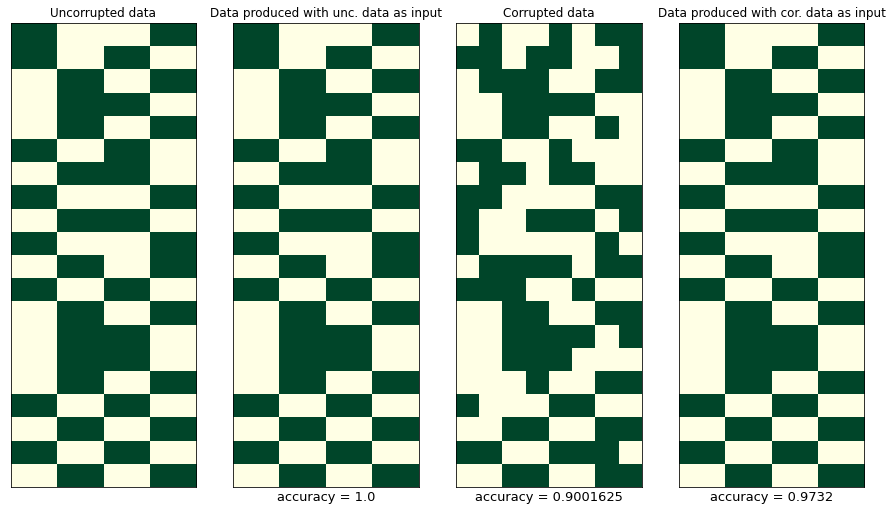

In [4]:
accs = np.zeros((3,3,3)) #GAPv GAPh genGAPh genGAPv M
x1,x2,x3 = 0, 0, 0
GAPv_range = [1,2,4]
GAPh_range = [1,2,4]
M_range = [2,3,4]

for GAPv in GAPv_range:
    for GAPh in GAPh_range:
        for M in M_range:
            w,a,b,acc,dw2_corr = rbm(vc, vc0, v0,
                            M = M,
                            l_rate = 1.0,
                            alpha = 0.05,
                            mini = 500, nepoch=5,
                            GAPv = GAPv, GAPh = GAPh, genGAPh = 64, genGAPv = 64)
            accs[x1,x2,x3]=acc
            x3 += 1
        x3 = 0
        x2 += 1
    x2=0
    x1 += 1
    
GAPv_index, GAPh_index, M_index = np.array(np.where(accs == accs.max())[:])[:,0]
GAPv = GAPv_range[GAPv_index]
GAPh = GAPh_range[GAPh_index]
M = M_range[M_index]
print(f'Best parameters for accuracy {accs.min()}: GAPv = {GAPv}, GAPh = {GAPh}, M = {M}')

w, a, b, acc, dw2_corr = rbm(vc, vc0, v0, GAPv = GAPv, GAPh = GAPh, genGAPh = 64 , genGAPv = 64, M = M, nepoch = 5) 
plot_result(v0,vc0,w,a,b, genGAPv = 64, genGAPh = 64)

We now plot how the weights gradients norm changes over time to show that the algorithm converges, i.e. the weights reach a stable value.

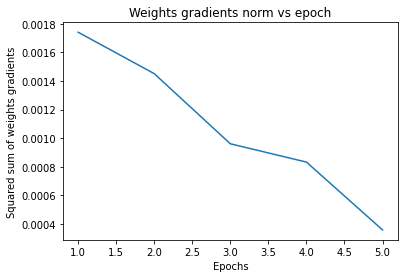

In [5]:
plt.plot(range(1,1+len(dw2_corr)),np.array(dw2_corr)/(L*M))
plt.title("Weights gradients norm vs epoch")
plt.xlabel("Epochs")
plt.ylabel("Squared sum of weights gradients")

plt.show()

# Training with grid search using clean data
As suggested in the review we repeat the above procedure, but this time we train using the uncorrupted data.

<ipython-input-3-310647497be0>:33: RuntimeWarning: overflow encountered in exp
  prob = 1. / (1. + np.exp(-DE*act))
Best parameters for accuracy 0.96985: GAPv = 4, GAPh = 1, M = 3


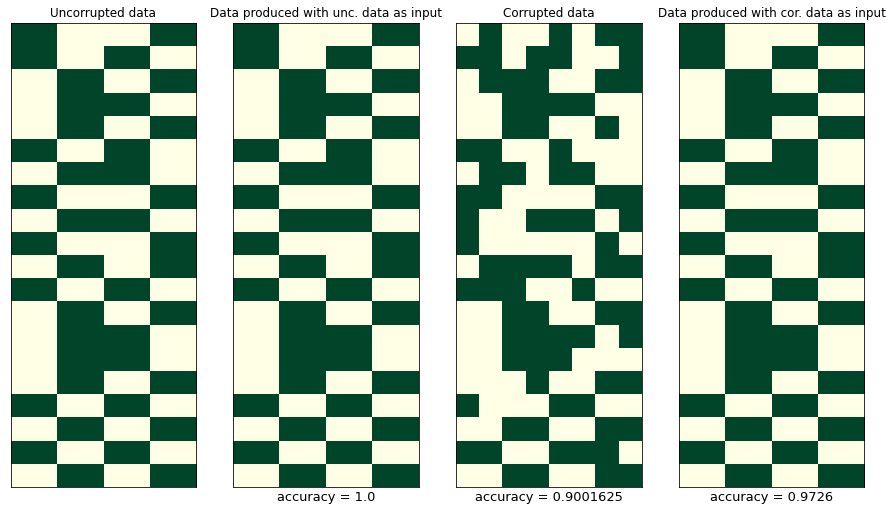

In [6]:
accs = np.zeros((3,3,3)) #GAPv GAPh genGAPh genGAPv M
x1,x2,x3 = 0, 0, 0
GAPv_range = [1,2,4]
GAPh_range = [1,2,4]
M_range = [2,3,4]

for GAPv in GAPv_range:
    for GAPh in GAPh_range:
        for M in M_range:
            w,a,b,acc,dw2_clean = rbm(v, vc0, v0,
                            M = M,
                            l_rate = 1.0,
                            alpha = 0.05,
                            mini = 500, nepoch=5,
                            GAPv = GAPv, GAPh = GAPh, genGAPh = 64, genGAPv = 64)
            accs[x1,x2,x3]=acc
            x3 += 1
        x3=0
        x2 += 1
    x2=0
    x1 += 1

GAPv_index, GAPh_index, M_index = np.array(np.where(accs == accs.max())[:])[:,0]
GAPv = GAPv_range[GAPv_index]
GAPh = GAPh_range[GAPh_index]

M = M_range[M_index]
print(f'Best parameters for accuracy {accs.min()}: GAPv = {GAPv}, GAPh = {GAPh}, M = {M}')

w, a, b, acc, dw2_clean = rbm(v, vc0, v0, GAPv = GAPv, GAPh = GAPh, genGAPh = 64 , genGAPv =64, M = M, nepoch = 5) 
plot_result(v0,vc0,w,a,b, genGAPv = 64, genGAPh = 64)

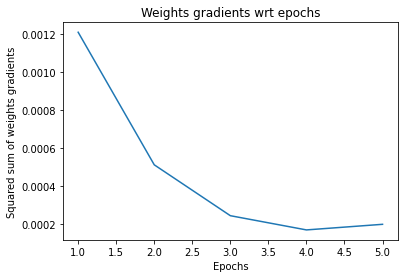

In [7]:
plt.plot(range(1,1+len(dw2_corr)),np.array(dw2_clean)/(L*M))
plt.title("Weights gradients wrt epochs")
plt.xlabel("Epochs")
plt.ylabel("Squared sum of weights gradients")

plt.show()

# Plotting model trained from clean data with best parameters

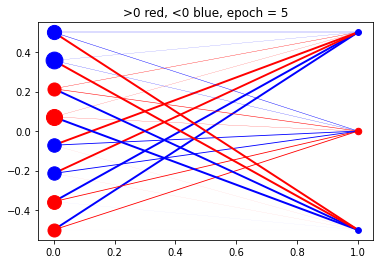

In [8]:
M = 3
(x1,y1) = create_coord(L,0)
(x2,y2) = create_coord(M,1)
plotgraph(5, w, a, b, L, M, x1, x2, y1, y2)

# Adding state 4
We now repeat the above procedure, but with an extra bit sequence in our data set; this means we need to generate new samples. In particular:                
We generated another set of data, adding the possibility to have the state number 4 (1,1,1,1,1,1,1,1).
As usual, we corrupted these data with a corruption rate of `q = 0.1` and we generated another file.

We plotted some data to check that they were properly corrupted and we computed the percentage of uncorrupted data, to check that the 90% of them maintain their original value.

In [9]:
# It pays to wrap these steps in some functions because we'll need to change q later

def generate_data(states, N = 10000, L = 8, q = 0.0, random_state = 1234, print_some_data = True) :
    y = np.zeros(N, dtype = int)
    x = np.zeros((N,L), dtype = int)
    max_key = len(states) - 1

    random.seed(random_state)
    for n in range(N) :
        # choose a random bit sequence for x[n]
        y[n] = key = random.randint(0, max_key) # randint includes both extrema
        x[n] = states[key]
        # corrupt with probability q each of x[n]'s bits
        for j in range(L) :
            if random.random() < q : # this is a rejection sampling based Bernoulli gen. with prob. = q
                x[n][j] = 1 - x[n][j]
    
    fname = f'DATA/dataRBM_q{q}_{max_key}.csv'
    with open(fname, mode='w') as myfile:
        writer = csv.writer(myfile, delimiter=',')
        for i in range(N):
            writer.writerow(x[i])

    #check the data
    if print_some_data is True :
        print(f"q = {q}")
        for i in range(10) :
            print(x[i],y[i])


def load_data(q, max_key, spins = False) :
    fname = f'DATA/dataRBM_q{q}_{max_key}.csv'
    data = np.loadtxt(fname, delimiter = ',', dtype = int)

    N = data.shape[0]
    L = data.shape[1]

    if spins :
        vmin = -1
        GAP = 2
        data = 2*data - 1
    else:
        vmin = 0
        GAP = 1
    
    return data, N, L, vmin, GAP

def generate_and_load_data(states, q, spins = False) : # this is useful to do everything in a single line
    generate_data(states = states, q = q, print_some_data = False)
    return load_data(q = q, max_key = (len(states) - 1), spins = spins)

In [10]:
states_4 = {0:[1,1,0,0,1,1,0,0],
            1:[0,0,1,1,1,1,0,0],
            2:[1,1,0,0,0,0,1,1],
            3:[0,0,1,1,0,0,1,1],
            4:[1,1,1,1,1,1,1,1]}

v, N, L, vmin, GAP = generate_and_load_data(states = states_4, q = 0.0)
vc, Nc, Lc, vmin, GAP = generate_and_load_data(states = states_4, q = 0.1)
v0, vc0 = v.copy(), vc.copy()
print(f"Percentage of uncorrupted data: {100*(v == vc).sum()/(N*L)}%")

Percentage of uncorrupted data: 89.945%


Then we trained the model for different values of M and GAP, to see how the accuracies vary when varying the temperature (GAP) and the number of Hidden Neurons (M).

We trained it firstly with the corrupted data and then with the clean data.

In [11]:
#TRAINING FROM CORRUPTED DATA

M = [2,3,4,5,6,7,8,9,10]
GAP = [0.5,1,2,3,4]

accuracies_corr = [[0] * len(M) for j in range(len(GAP))]

for j in range(len(GAP)):
    for i in range(len(M)):
        w,a,b,acc, dw2_corr1 = rbm(vc, vc0, v0,  #training with corrupted data
                                M = M[i],
                                l_rate = 1.0,
                                alpha = 0.05,
                                mini = 500, nepoch=5,
                                GAPv = GAP[j], GAPh = GAP[j], genGAPh = 64, genGAPv = 64)
        accuracies_corr[j][i] = acc


In [12]:
#TRAINING FROM CLEAN DATA
accuracies_clean = [[0] * len(M) for j in range(len(GAP))]

for j in range(len(GAP)):
    for i in range(len(M)):
        w,a,b,acc, dw2_clean1 = rbm(v, vc0, v0,  #training with uncorrupted data
                                M = M[i],
                                l_rate = 1.0,
                                alpha = 0.05,
                                mini = 500, nepoch=5,
                                GAPv = GAP[j], GAPh = GAP[j], genGAPh = 64, genGAPv = 64)
        accuracies_clean[j][i] = acc
    

<ipython-input-3-310647497be0>:33: RuntimeWarning: overflow encountered in exp
  prob = 1. / (1. + np.exp(-DE*act))


# Plotting the variation of accuracies for different `M` and temperature values

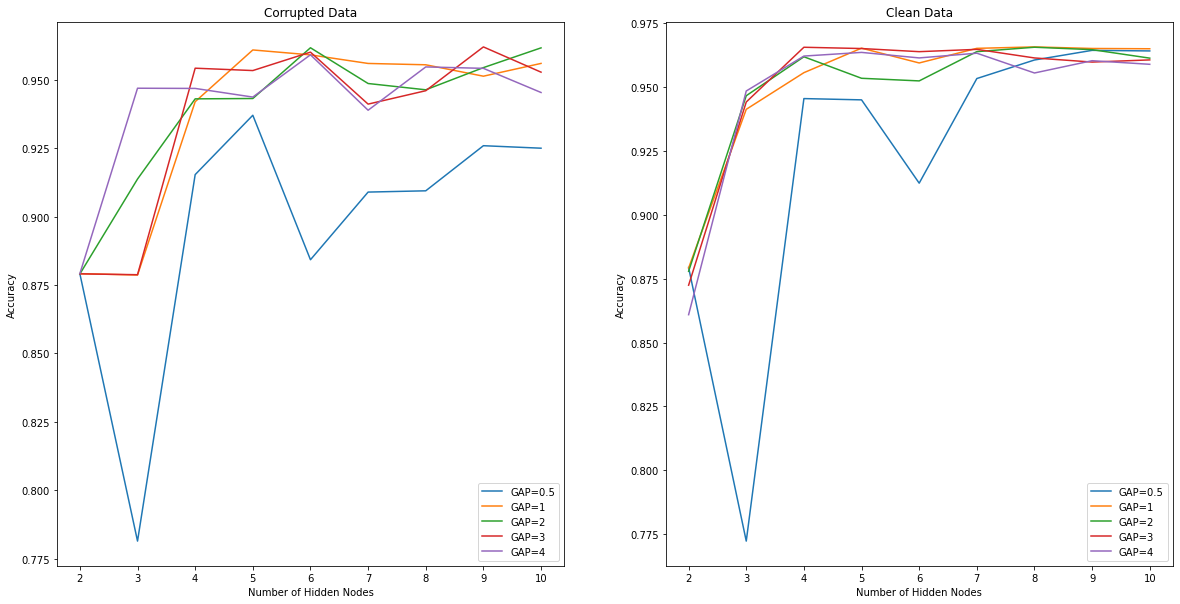

In [13]:
#plot the Variation of accuracies for different M and different temperatures
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
for i in range(len(GAP)): ax[0].plot(M,accuracies_corr[i])
ax[0].set_xlabel("Number of Hidden Nodes")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Corrupted Data")
ax[0].legend(['GAP=0.5','GAP=1','GAP=2','GAP=3','GAP=4'], loc='lower right')

for i in range(len(GAP)): ax[1].plot(M,accuracies_clean[i])
ax[1].set_xlabel("Number of Hidden Nodes")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Clean Data")
ax[1].legend(['GAP=0.5','GAP=1','GAP=2','GAP=3','GAP=4'], loc='lower right')

plt.show()

As we can see, when training the model with the Corrupted Data, the accuracy's behaviour it's quite unstable. In general, we observe that the higher the temperature the worse are the accuracy results. For the corrupted data trained model we reach a reasonable value for the accuracy with at least **8/9 Hidden Nodes**, not considering the GAP=0.5.

On the other hand, when training the model with clean data we easily reach a stabler behaviour of the accuracy; with just **4 Hidden Nodes** the majority of the temperatures guarantee a reasonable value of accuracy. Of course the highest temperature always behaves in a more unstable way, but eventually reaches a good accuracy level with more than 7 Hidden Nodes.

# Adding state 5

We generated a second set of data, containing also the possibility to have state 5 (1,0,1,0,1,0,0,0) and we repeated the previous passages.

In [14]:
states_5 = {0:[1,1,0,0,1,1,0,0],
            1:[0,0,1,1,1,1,0,0],
            2:[1,1,0,0,0,0,1,1],
            3:[0,0,1,1,0,0,1,1],
            4:[1,1,1,1,1,1,1,1],
            5:[1,0,1,0,1,0,0,0]}

v, N, L, vmin, GAP = generate_and_load_data(states = states_5, q = 0.0)
vc, Nc, Lc, vmin, GAP = generate_and_load_data(states = states_5, q = 0.1)
v0, vc0 = v.copy(), vc.copy()
print(f"Percentage of uncorrupted data: {100*(v == vc).sum()/(N*L)}%")

Percentage of uncorrupted data: 89.84%


In [15]:
#TRAINING FROM CORRUPTED DATA

M = [2,3,4,5,6,7,8,9,10]
GAP = [0.5,1,2,3,4]

accuracies_corr = [[0] * len(M) for j in range(len(GAP))]

for j in range(len(GAP)):
    for i in range(len(M)):
        w,a,b,acc, dw2_corr2 = rbm(vc, vc0, v0,  #training using corrupted data
                                M = M[i],
                                l_rate = 1.0,
                                alpha = 0.05,
                                mini = 500, nepoch=5,
                                GAPv = GAP[j], GAPh = GAP[j], genGAPh = 64, genGAPv = 64)
        accuracies_corr[j][i] = acc


In [16]:
#TRAINING FROM CLEAN DATA

M = [2,3,4,5,6,7,8,9,10]
GAP = [0.5,1,2,3,4]

accuracies_clean = [[0] * len(M) for j in range(len(GAP))]

for j in range(len(GAP)):
    for i in range(len(M)):
        w,a,b,acc,dw2_clean2  = rbm(v, vc0, v0,  #training using uncorrupted data
                                M = M[i],
                                l_rate = 1.0,
                                alpha = 0.05,
                                mini = 500, nepoch=5,
                                GAPv = GAP[j], GAPh = GAP[j], genGAPh = 64, genGAPv = 64)
        accuracies_clean[j][i] = acc
    

<ipython-input-3-310647497be0>:33: RuntimeWarning: overflow encountered in exp
  prob = 1. / (1. + np.exp(-DE*act))


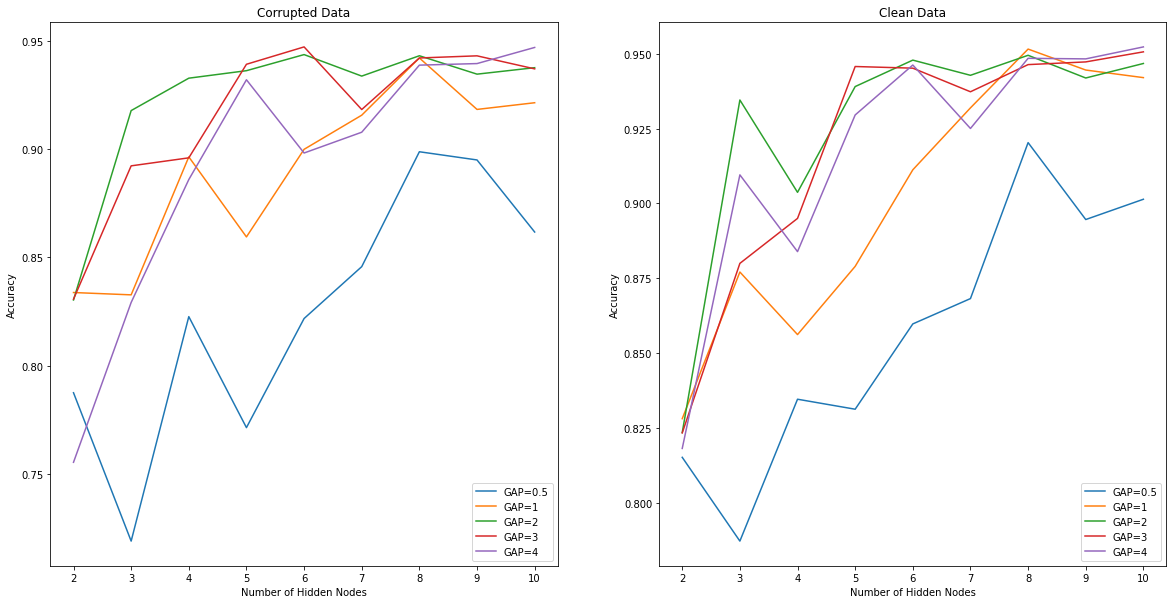

In [17]:
#plot the Variation of accuracies for different M and different temperatures

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
for i in range(len(GAP)): ax[0].plot(M,accuracies_corr[i])
ax[0].set_xlabel("Number of Hidden Nodes")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Corrupted Data")
ax[0].legend(['GAP=0.5','GAP=1','GAP=2','GAP=3','GAP=4'], loc='lower right')

for i in range(len(GAP)): ax[1].plot(M,accuracies_clean[i])
ax[1].set_xlabel("Number of Hidden Nodes")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Clean Data")
ax[1].legend(['GAP=0.5','GAP=1','GAP=2','GAP=3','GAP=4'], loc='lower right')

plt.show()

With the data containing the state 5, the behaviours of the accuracies are a bit more unstable, but it remains true that generally lower temperatures lead to better results.

For the corrupted data trained model we reach a reasonable accuracy with at least **8 Hidden Nodes**, not considering the value corresponding to GAP=0.5. For the clean data trained model, the higher temperatures (GAP=4,3,2) reach a good accuracy with just **6 Hidden Nodes**, while the lower temperature (GAP=1) needs at least **8 Hidden Nodes**.

## What happens if we change spins value convention from {0,1} to {-1,1}?
We decide to plot how the squared sum all over rows and columns of $v$ vectors of gradients `dw` vary by changing spins values. We notice that the results are substantially different, why does it happen?
Even though a simple convention on spins values shouldn't perturb the final result of the RBM, the latter has been built in a kind of "model dependent" way. In particular the activation function that determines if a neuron "fires" or not has been endowed with a scalar product between the weights and the spins values. This means that by using the first convention ({0,1} spins) weights corresponding to zero spins are not considered during training, whereas the others are kept. By choosing the second convention, {-1,1} spins, weights previously correlated to zero spins influence now the training schedule - and the fact that now they're no longer multiplied by zero means every weight is always involved in the training procedure.                      
This is vaguely reminiscent of dropout vs no dropout in neural networks, where we may choose to randomly ignore some weights in a given epoch - which makes convergence slower but more stable. This analogy is enough to let us predict that the -1 convention will make $dw^2$ greater (more frequent/significant weight updates) but also more rapidly decreasing, whereas we expect that in the 0 convention $dw^2$ will be smaller but almost constant (at least if compared to the other convention).

In [18]:
# computing dw2 values  in the convention {0,1}
M = 8
GAP = 4

accuracies_corr = [0]
w,a,b,acc, dw2_corr2 = rbm(vc, vc0, v0,
                            M = M,
                            l_rate = 1.0,
                            alpha = 0.05,
                            mini = 500, nepoch=5,
                            GAPv = GAP, GAPh = GAP, genGAPh = 64, genGAPv = 64)
accuracies_corr2 = acc

In [19]:
# let's train the model with key word argument in loading data function SPINS=TRUE. We choose also M=8 and GAP=4 to make an example.

states_5 = {0:[1,1,0,0,1,1,0,0],
            1:[0,0,1,1,1,1,0,0],
            2:[1,1,0,0,0,0,1,1],
            3:[0,0,1,1,0,0,1,1],
            4:[1,1,1,1,1,1,1,1],
            5:[1,0,1,0,1,0,0,0]}

v, N, L, vmin, GAP = generate_and_load_data(states = states_5, q = 0.0, spins = True)
vc, Nc, Lc, vmin, GAP = generate_and_load_data(states = states_5, q = 0.1, spins = True)
v0, vc0 = v.copy(), vc.copy()
print(f"Percentage of uncorrupted data: {100*(v == vc).sum()/(N*L)}%")

Percentage of uncorrupted data: 89.84%


In [20]:
M = 8
GAP = 4

accuracies_corr = [0]
w,a,b,acc, dw2_corr2_new = rbm(vc, vc0, v0,
                            M = M,
                            l_rate = 1.0,
                            alpha = 0.05,
                            mini = 500, nepoch=5,
                            GAPv = GAP, GAPh = GAP, genGAPh = 64, genGAPv = 64)
accuracies_corr2_new = acc

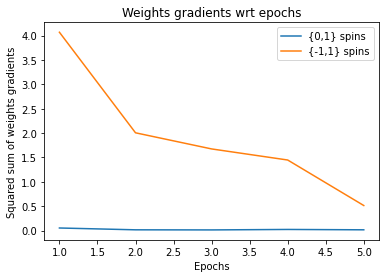

In [21]:
fig, ax = plt.subplots()
ax.plot(range(1,6),dw2_corr2, label="{0,1} spins")
ax.plot(range(1,6),dw2_corr2_new,label="{-1,1} spins")
plt.title("Weights gradients wrt epochs")
plt.xlabel("Epochs")
plt.ylabel("Squared sum of weights gradients")
ax.legend()

plt.show()

Thanks to the above plots we notice that the weights gradients norm behaves as expected.

# Using `q = 0.2` (states 0-4)

In [22]:
states_4 = {0:[1,1,0,0,1,1,0,0],
            1:[0,0,1,1,1,1,0,0],
            2:[1,1,0,0,0,0,1,1],
            3:[0,0,1,1,0,0,1,1],
            4:[1,1,1,1,1,1,1,1]}

v, N, L, vmin, GAP = generate_and_load_data(states = states_4, q = 0.0)
vc, Nc, Lc, vmin, GAP = generate_and_load_data(states = states_4, q = 0.2)
v0, vc0 = v.copy(), vc.copy()
print(f"Percentage of uncorrupted data: {100*(v == vc).sum()/(N*L)}%")

Percentage of uncorrupted data: 80.03875%


In [23]:
#TRAINING FROM CORRUPTED DATA

M = [2,3,4,5,6,7,8,9,10]
GAP = [0.5,1,2,3,4]

accuracies_corr = [[0] * len(M) for j in range(len(GAP))]

for j in range(len(GAP)):
    for i in range(len(M)):
        w,a,b,acc, dw2_corr1 = rbm(vc, vc0, v0,  #training with corrupted data
                                M = M[i],
                                l_rate = 1.0,
                                alpha = 0.05,
                                mini = 500, nepoch=5,
                                GAPv = GAP[j], GAPh = GAP[j], genGAPh = 64, genGAPv = 64)
        accuracies_corr[j][i] = acc


In [24]:
#TRAINING FROM CLEAN DATA
accuracies_clean = [[0] * len(M) for j in range(len(GAP))]

for j in range(len(GAP)):
    for i in range(len(M)):
        w,a,b,acc, dw2_clean1 = rbm(v, vc0, v0,  #training with uncorrupted data
                                M = M[i],
                                l_rate = 1.0,
                                alpha = 0.05,
                                mini = 500, nepoch=5,
                                GAPv = GAP[j], GAPh = GAP[j], genGAPh = 64, genGAPv = 64)
        accuracies_clean[j][i] = acc
    

<ipython-input-3-310647497be0>:33: RuntimeWarning: overflow encountered in exp
  prob = 1. / (1. + np.exp(-DE*act))


# Plotting the variation of accuracies for different `M` and temperature values

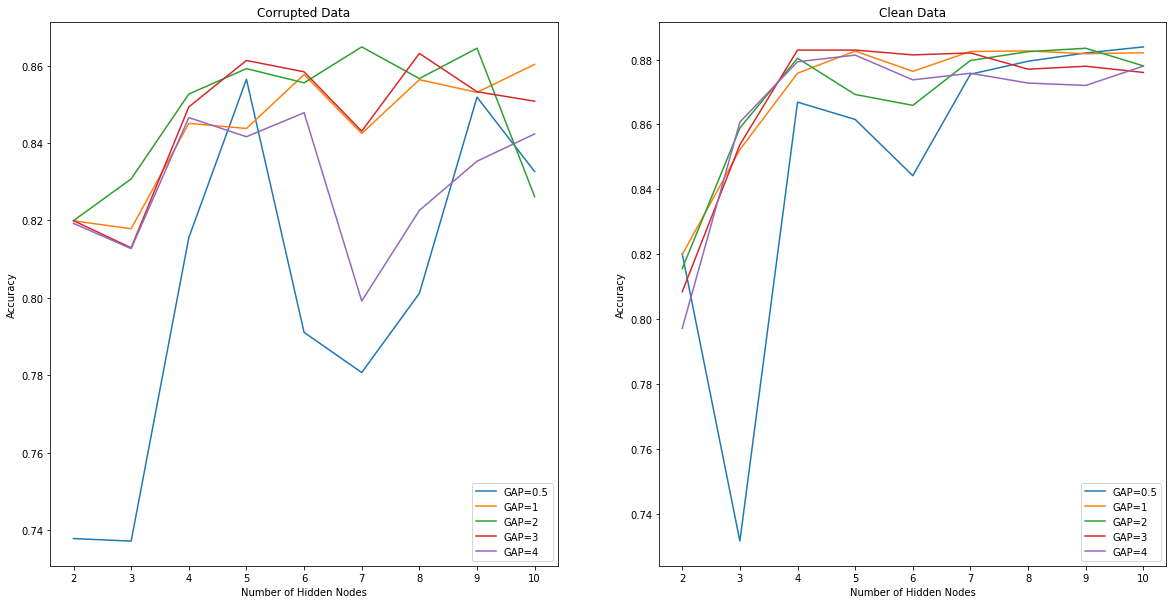

In [25]:
#plot the Variation of accuracies for different M and different temperatures
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
for i in range(len(GAP)): ax[0].plot(M,accuracies_corr[i])
ax[0].set_xlabel("Number of Hidden Nodes")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Corrupted Data")
ax[0].legend(['GAP=0.5','GAP=1','GAP=2','GAP=3','GAP=4'], loc='lower right')

for i in range(len(GAP)): ax[1].plot(M,accuracies_clean[i])
ax[1].set_xlabel("Number of Hidden Nodes")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Clean Data")
ax[1].legend(['GAP=0.5','GAP=1','GAP=2','GAP=3','GAP=4'], loc='lower right')

plt.show()

# Using `q = 0.2` (states 0-5)

In [26]:
states_5 = {0:[1,1,0,0,1,1,0,0],
            1:[0,0,1,1,1,1,0,0],
            2:[1,1,0,0,0,0,1,1],
            3:[0,0,1,1,0,0,1,1],
            4:[1,1,1,1,1,1,1,1],
            5:[1,0,1,0,1,0,0,0]}

v, N, L, vmin, GAP = generate_and_load_data(states = states_5, q = 0.0)
vc, Nc, Lc, vmin, GAP = generate_and_load_data(states = states_5, q = 0.2)
v0, vc0 = v.copy(), vc.copy()
print(f"Percentage of uncorrupted data: {100*(v == vc).sum()/(N*L)}%")

Percentage of uncorrupted data: 79.84625%


In [27]:
#TRAINING FROM CORRUPTED DATA

M = [2,3,4,5,6,7,8,9,10]
GAP = [0.5,1,2,3,4]

accuracies_corr = [[0] * len(M) for j in range(len(GAP))]

for j in range(len(GAP)):
    for i in range(len(M)):
        w,a,b,acc, dw2_corr2 = rbm(vc, vc0, v0,  #training using corrupted data
                                M = M[i],
                                l_rate = 1.0,
                                alpha = 0.05,
                                mini = 500, nepoch=5,
                                GAPv = GAP[j], GAPh = GAP[j], genGAPh = 64, genGAPv = 64)
        accuracies_corr[j][i] = acc


In [28]:
#TRAINING FROM CLEAN DATA

M = [2,3,4,5,6,7,8,9,10]
GAP = [0.5,1,2,3,4]

accuracies_clean = [[0] * len(M) for j in range(len(GAP))]

for j in range(len(GAP)):
    for i in range(len(M)):
        w,a,b,acc,dw2_clean2  = rbm(v, vc0, v0,  #training using uncorrupted data
                                M = M[i],
                                l_rate = 1.0,
                                alpha = 0.05,
                                mini = 500, nepoch=5,
                                GAPv = GAP[j], GAPh = GAP[j], genGAPh = 64, genGAPv = 64)
        accuracies_clean[j][i] = acc
    

<ipython-input-3-310647497be0>:33: RuntimeWarning: overflow encountered in exp
  prob = 1. / (1. + np.exp(-DE*act))


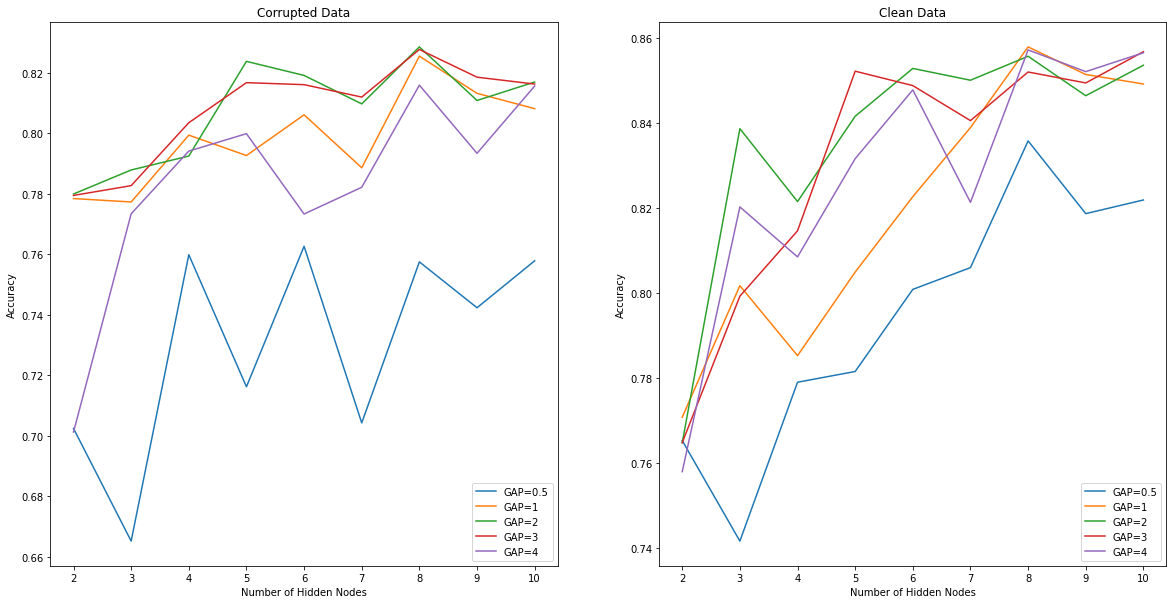

In [29]:
#plot the Variation of accuracies for different M and different temperatures

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
for i in range(len(GAP)): ax[0].plot(M,accuracies_corr[i])
ax[0].set_xlabel("Number of Hidden Nodes")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Corrupted Data")
ax[0].legend(['GAP=0.5','GAP=1','GAP=2','GAP=3','GAP=4'], loc='lower right')

for i in range(len(GAP)): ax[1].plot(M,accuracies_clean[i])
ax[1].set_xlabel("Number of Hidden Nodes")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Clean Data")
ax[1].legend(['GAP=0.5','GAP=1','GAP=2','GAP=3','GAP=4'], loc='lower right')

plt.show()

With a higher corruption rate even though the overall trend wrt temperature is the same we notice everything is shifted down a bit, which means that the rbm struggles a bit more. This is reasonable; we upped the difficulty of the task but didn't improve the architecture accordingly (e.g. we performed a grid search over the same values of the parameters).